In [0]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

## Using Logistic Model
### https://www.kaggle.com/rizkyalifr/logistic-model-for-indonesia-covid-19

In [0]:
# df=pd.read_csv('indonesia-coronavirus-cases/confirmed_acc.csv')
# df = df.loc[:,['date','cases']]
# FMT = '%m/%d/%Y'

link_cases = 'https://gist.githubusercontent.com/andreasnovian/bd91a4a4d93329f022669aaf8c51f2ab/raw/563d7b1c1c9cfa7c92655ce1138af9fe60d13975/cases.csv'
df = pd.read_csv(link_cases, sep = ",")
df = df.loc[:,['date','acc_deceased']]
df = df.dropna()
FMT = '%d-%b-%y'

date = df['date']
# df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("1/22/2020", FMT)).days  )
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("1-Mar-20", FMT)).days  )

In [232]:
print(df)

    date  acc_deceased
0      1             0
1      2             0
2      3             0
3      4             0
4      5             0
5      6             0
6      7             0
7      8             0
8      9             0
9     10             2
10    11             4
11    12             4
12    13             5
13    14             5
14    15             5
15    16             7
16    17            19
17    18            25
18    19            32
19    20            38
20    21            48
21    22            49
22    23            55
23    24            58
24    25            78
25    26            87
26    27           102
27    28           114
28    29           122


In [0]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [234]:
x = list(df.iloc[1:,0])
y = list(df.iloc[1:,1])

fit = curve_fit(logistic_model,x,y)

A,B = fit
#nilai a,b,c
A

array([  4.06428257,  26.21003768, 183.38736144])

In [235]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
errors

[0.32627036513349844, 1.047173835144449, 22.12642329715683]

In [0]:
#Kemungkinan terburuk
a=A[0]+errors[0]
b=A[1]+errors[1]
c=A[2]+errors[2]

In [237]:
#Jumlah hari maksimal dari 2 Maret 
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
sol

53

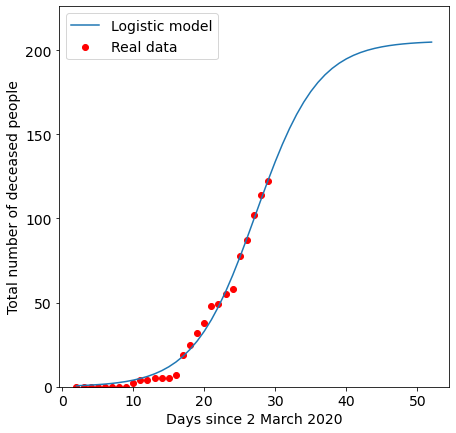

In [238]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)# Real data
plt.scatter(x,y,label="Real data",color="red")

# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,a,b,c) for i in x+pred_x], label="Logistic model" )

plt.legend()
plt.xlabel("Days since 2 March 2020")
plt.ylabel("Total number of deceased people")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()

In [239]:
pred_y = [logistic_model(i,a,b,c) for i in pred_x]

for i in range(10):
    
    days = pred_x[i]
    date = datetime.strptime("1-Mar-20", "%d-%b-%y") + timedelta(days=days)
    date = date.isoformat()
    print('Tanggal',date,'Jumlah Korban Meninggal',pred_y[i])

Tanggal 2020-03-30T00:00:00 Jumlah Korban Meninggal 122.88745507998115
Tanggal 2020-03-31T00:00:00 Jumlah Korban Meninggal 133.84850864467575
Tanggal 2020-04-01T00:00:00 Jumlah Korban Meninggal 144.08238001860835
Tanggal 2020-04-02T00:00:00 Jumlah Korban Meninggal 153.42358437219158
Tanggal 2020-04-03T00:00:00 Jumlah Korban Meninggal 161.77556047732784
Tanggal 2020-04-04T00:00:00 Jumlah Korban Meninggal 169.1061843965032
Tanggal 2020-04-05T00:00:00 Jumlah Korban Meninggal 175.4366050812748
Tanggal 2020-04-06T00:00:00 Jumlah Korban Meninggal 180.82700134279773
Tanggal 2020-04-07T00:00:00 Jumlah Korban Meninggal 185.3623034979278
Tanggal 2020-04-08T00:00:00 Jumlah Korban Meninggal 189.13985441647648


In [240]:
y_pred_logistic = [logistic_model(i,a,b,c) for i in x]
p=mean_squared_error(y,y_pred_logistic)

s1=(np.subtract(y,y_pred_logistic)**2).sum()
s2=(np.subtract(y,np.mean(y))**2).sum()
r=1-s1/s2
print("R^2 adalah {}".format(r))
print("Mean square errornya adalah {}".format(p))

R^2 adalah 0.9905335876756898
Mean square errornya adalah 13.622203558198928


In [0]:
from datetime import timedelta, date
from datetime import datetime  
from datetime import timedelta 

start_date = "1/03/20"

date_1 = datetime.strptime(start_date, "%d/%m/%y")

end_date = date_1 + timedelta(days=sol)

end = end_date.strftime("%d %b %Y")

In [250]:
print("Jumlah maksimal pasien meninggal di Indonesia menurut prediksi adalah {:f}".format(A[2]+errors[2])) #Penambahan dengan error
# print("Wabah akan berakhir {:.0f} hari setelah 1 Maret 2020 atau {}". format(sol,end))

Jumlah maksimal pasien meninggal di Indonesia menurut prediksi adalah 205.513785


## Using Prediction Tool: FBProphet
### https://www.kaggle.com/ardisragen/predicting-coronavirus-positive-cases-in-indonesia

In [243]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from fbprophet import Prophet

In [244]:
# link_confirmed_acc = 'https://gist.githubusercontent.com/andreasnovian/e608523a06013478847b171c69a9287c/raw/6d7984d9a31b27657d9822cefdf5e755c650079f/confirmed_acc.csv'
# data = pd.read_csv(link_confirmed_acc, sep = ",")

# print(data.tail())

link_cases = 'https://gist.githubusercontent.com/andreasnovian/bd91a4a4d93329f022669aaf8c51f2ab/raw/563d7b1c1c9cfa7c92655ce1138af9fe60d13975/cases.csv'
data = pd.read_csv(link_cases, sep = ",")
data = data.loc[:,['date','acc_deceased']]
data = data.dropna()

print(data.tail())

         date  acc_deceased
24  26-Mar-20            78
25  27-Mar-20            87
26  28-Mar-20           102
27  29-Mar-20           114
28  30-Mar-20           122


In [245]:
end = datetime.datetime.now() - datetime.timedelta(1)
date_index = pd.date_range('2020-03-02', end)

fig = px.area(data, x=date_index, y='acc_deceased' )
fig.show()

In [246]:
df_prophet = data.rename(columns={"date": "ds", "acc_deceased": "y"})
df_prophet.tail()

,ds,y
24,26-Mar-20,78
25,27-Mar-20,87
26,28-Mar-20,102
27,29-Mar-20,114
28,30-Mar-20,122


In [247]:
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot

m = Prophet(
    changepoint_prior_scale=0.3, # increasing it will make the trend more flexible
    changepoint_range=0.99, # place potential changepoints in the first 95% of the time series
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(df_prophet)

future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
29,2020-03-31,134.592257,132.635004,136.593150
30,2020-04-01,145.654609,143.302031,148.459194
31,2020-04-02,156.716961,153.075232,161.089983
32,2020-04-03,167.779313,162.449999,173.975409
33,2020-04-04,178.841666,171.202181,187.127454
34,2020-04-05,189.904018,179.545878,200.823254
35,2020-04-06,200.966370,187.889558,214.502246
36,2020-04-07,212.028723,195.571827,228.436224
37,2020-04-08,223.091075,203.461005,243.983636
38,2020-04-09,234.153427,211.307516,257.922008


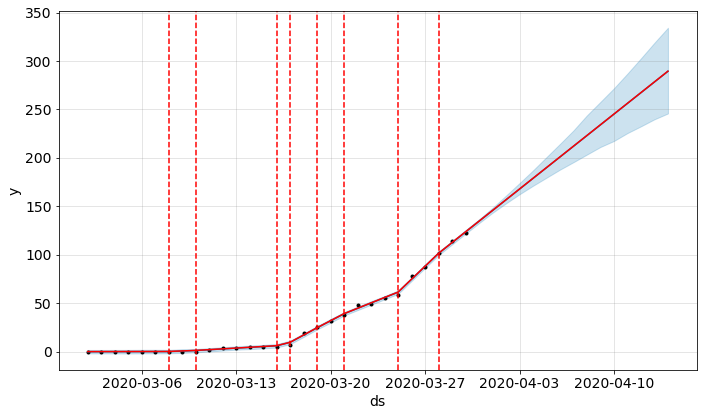

In [248]:
fig = plot_plotly(m, forecast)
py.iplot(fig) 

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [249]:
forecast[29:40]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
29,2020-03-31,134.700703,132.635004,136.593150,134.285104,135.245747,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,0.0,0.0,0.0,134.592257
30,2020-04-01,145.763055,143.302031,148.459194,144.202779,147.792317,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,0.0,0.0,0.0,145.654609
31,2020-04-02,156.825408,153.075232,161.089983,153.554687,160.587891,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,0.0,0.0,0.0,156.716961
32,2020-04-03,167.887760,162.449999,173.975409,162.651256,173.789685,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,0.0,0.0,0.0,167.779313
33,2020-04-04,178.950112,171.202181,187.127454,171.828050,187.478213,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,0.0,0.0,0.0,178.841666
34,2020-04-05,190.012464,179.545878,200.823254,179.830847,200.885302,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,0.0,0.0,0.0,189.904018
35,2020-04-06,201.074817,187.889558,214.502246,188.157763,214.579256,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,0.0,0.0,0.0,200.966370
36,2020-04-07,212.137169,195.571827,228.436224,195.617364,228.724261,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,0.0,0.0,0.0,212.028723
37,2020-04-08,223.199521,203.461005,243.983636,203.328386,243.143795,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,0.0,0.0,0.0,223.091075
38,2020-04-09,234.261874,211.307516,257.922008,210.509330,257.818307,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,-0.108446,0.0,0.0,0.0,234.153427
